# Overview

In this notebook, we will do some data visualization work and prepare the data to what we need to. After that, we will use pycaret to pick iup the best accuracy model to solve this question.

In [1]:
%%capture
!pip install pycaret==3.3.0

In [2]:
import os
import pandas as pd
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

warnings.filterwarnings('ignore')

# Loading and Checking the Dataset

In [3]:
train=pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
submission=pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [4]:
train.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.000,20758.000,20758.000,20758.000,20758.000,20758.000,20758.000,20758.000,20758.000
mean,10378.500,23.842,1.700,87.888,2.446,2.761,2.029,0.982,0.617
std,5992.463,5.688,0.087,26.379,0.533,0.705,0.608,0.838,0.602
min,0.000,14.000,1.450,39.000,1.000,1.000,1.000,0.000,0.000
25%,5189.250,20.000,1.632,66.000,2.000,3.000,1.792,0.008,0.000
50%,10378.500,22.815,1.700,84.065,2.394,3.000,2.000,1.000,0.574
75%,15567.750,26.000,1.763,111.601,3.000,3.000,2.550,1.587,1.000
max,20757.000,61.000,1.976,165.057,3.000,4.000,3.000,3.000,2.000


In [5]:
def check_df(df):
    print("############# Shape #############")
    print(df.shape)
    print("############# Types #############")
    print(df.dtypes)
    print("############# NA #############")
    print(df.isnull().sum())
    print("############# Quantiles #############")
    numeric_columns=df.select_dtypes(include=['number']).columns
    # return values at the given quantile over requested axis
    print(df[numeric_columns].quantile([0,0.05,0.50,0.95,0.99], 1).T)
    

check_df(train)

############# Shape #############
(20758, 18)
############# Types #############
id                                  int64
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object
############# NA #############
id                                0
Gender                            0
Age                               0
Height     

In [6]:
train.head().T

,0,1,2,3,4
id,0,1,2,3,4
Gender,Male,Female,Female,Female,Male
Age,24.443,18.000,18.000,20.953,31.641
Height,1.700,1.560,1.711,1.711,1.914
Weight,81.670,57.000,50.166,131.275,93.798
family_history_with_overweight,yes,yes,yes,yes,yes
FAVC,yes,yes,yes,yes,yes
FCVC,2.000,2.000,1.881,3.000,2.680
NCP,2.983,3.000,1.412,3.000,1.971
CAEC,Sometimes,Frequently,Sometimes,Sometimes,Sometimes


# Visualization Data

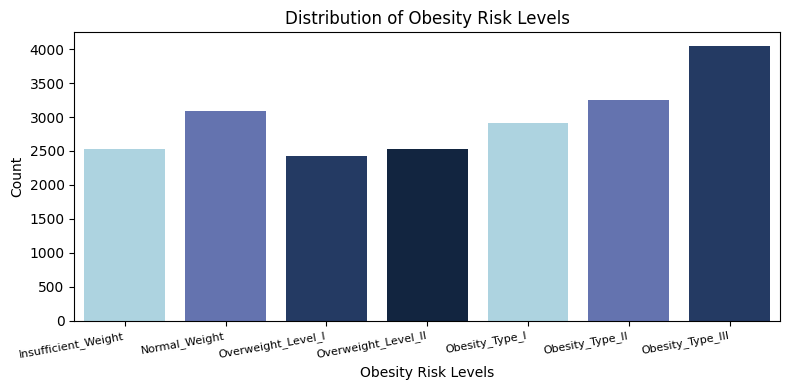

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

target=train["NObeyesdad"]
color_list=["#A5D7E8", "#576CBC", "#19376D", "#0B2447"]
cmap_custom=ListedColormap(color_list)

sorted_labels = ['Insufficient_Weight', 'Normal_Weight', 
 'Overweight_Level_I', 'Overweight_Level_II', 
 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

plt.figure(figsize=(8,4))
ax=sns.countplot(x=target, order=sorted_labels, palette=color_list)

plt.title('Distribution of Obesity Risk Levels')
plt.xlabel('Obesity Risk Levels')
plt.ylabel('Count')

ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

# Setting up a Target

In [8]:
from pycaret.classification import setup

sp=setup(train, target='NObeyesdad', experiment_name='obesity_prediction', session_id=2024)
sp

,Description,Value
0,Session id,2024
1,Target,NObeyesdad
2,Target type,Multiclass
3,Target mapping,"Insufficient_Weight: 0, Normal_Weight: 1, Obesity_Type_I: 2, Obesity_Type_II: 3, Obesity_Type_III: 4, Overweight_Level_I: 5, Overweight_Level_II: 6"
4,Original data shape,"(20758, 18)"
5,Transformed data shape,"(20758, 27)"
6,Transformed train set shape,"(14530, 27)"
7,Transformed test set shape,"(6228, 27)"
8,Numeric features,9
9,Categorical features,8


# Comparing the Model Accuracy

In [9]:
from pycaret.classification import compare_models

best=compare_models(n_select=1)
best

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9070,0.0000,0.9070,0.9072,0.9069,0.8909,0.8910,2.8000
xgboost,Extreme Gradient Boosting,0.9065,0.0000,0.9065,0.9067,0.9063,0.8904,0.8905,4.0520
gbc,Gradient Boosting Classifier,0.9064,0.0000,0.9064,0.9063,0.9062,0.8902,0.8903,23.1750
catboost,CatBoost Classifier,0.9064,0.0000,0.9064,0.9066,0.9062,0.8902,0.8903,20.3750
rf,Random Forest Classifier,0.8962,0.0000,0.8962,0.8965,0.8957,0.8782,0.8784,3.0170
et,Extra Trees Classifier,0.8669,0.0000,0.8669,0.8671,0.8662,0.8438,0.8441,2.6770
dt,Decision Tree Classifier,0.8498,0.0000,0.8498,0.8500,0.8496,0.8238,0.8239,0.5070
lda,Linear Discriminant Analysis,0.8216,0.0000,0.8216,0.8199,0.8196,0.7907,0.7911,0.4330
qda,Quadratic Discriminant Analysis,0.6893,0.0000,0.6893,0.6984,0.6675,0.6352,0.6478,0.3870
nb,Naive Bayes,0.6765,0.0000,0.6765,0.6821,0.6607,0.6195,0.6264,0.3840


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=2024, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

# Finalize Model

In [10]:
from pycaret.classification import finalize_model, predict_model

finalized_model=finalize_model(best)
predict_model(finalized_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9774,0.9994,0.9774,0.9773,0.9773,0.9734,0.9735


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,prediction_label,prediction_score
16716,16716,Female,26.000,1.628,105.037,yes,yes,3.000,3.000,Sometimes,no,2.609,no,0.000,0.504,Sometimes,Public_Transportation,Obesity_Type_III,Obesity_Type_III,1.000
19844,19844,Female,25.128,1.703,102.921,yes,yes,3.000,3.000,Sometimes,no,1.043,no,0.051,0.912,Sometimes,Public_Transportation,Obesity_Type_III,Obesity_Type_III,1.000
14852,14852,Female,19.000,1.540,56.000,yes,yes,3.000,1.000,Sometimes,no,2.000,no,2.000,0.000,no,Public_Transportation,Normal_Weight,Normal_Weight,0.947
11865,11865,Female,22.910,1.650,80.000,yes,yes,2.000,1.000,Sometimes,no,2.000,no,0.898,1.000,no,Public_Transportation,Overweight_Level_II,Overweight_Level_II,0.636
8467,8467,Female,21.997,1.526,42.000,no,yes,3.000,2.044,Frequently,no,1.656,no,0.998,0.000,Sometimes,Public_Transportation,Insufficient_Weight,Insufficient_Weight,0.999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19823,19823,Male,32.708,1.719,85.000,yes,yes,2.000,1.924,Sometimes,no,1.640,no,0.917,0.000,no,Automobile,Overweight_Level_II,Overweight_Level_II,0.985
1220,1220,Male,27.266,1.779,120.152,yes,yes,2.767,3.000,Sometimes,no,2.095,no,1.510,0.000,Sometimes,Automobile,Obesity_Type_II,Obesity_Type_II,0.998
12698,12698,Male,22.976,1.849,121.237,yes,yes,2.397,2.893,Sometimes,no,2.550,no,1.856,0.003,Sometimes,Public_Transportation,Obesity_Type_II,Obesity_Type_II,0.997
5839,5839,Male,21.835,1.650,80.458,yes,yes,2.000,2.693,Sometimes,no,2.000,no,0.976,1.191,no,Public_Transportation,Overweight_Level_II,Overweight_Level_II,0.980


# Visualization Features

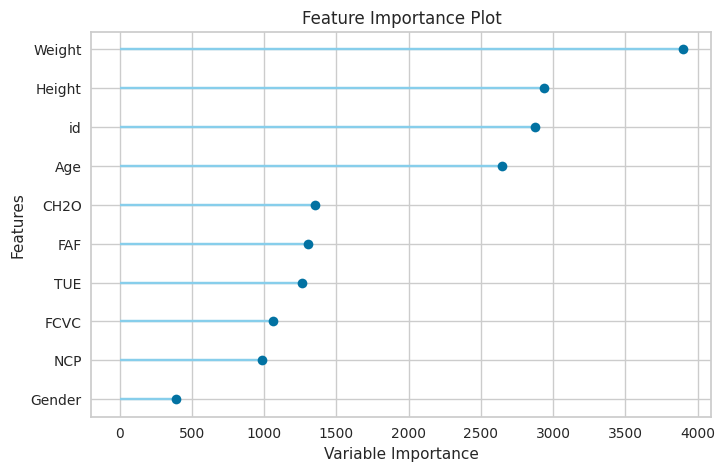

In [11]:
from pycaret.classification import plot_model

plot_model(finalized_model, plot='feature')

# Making Predictions

In [12]:
preditions=predict_model(finalized_model, data=test, raw_score=True)
preditions.head().T

,0,1,2,3,4
id,20758,20759,20760,20761,20762
Gender,Male,Female,Female,Male,Female
Age,26.900,21.000,26.000,20.979,26.000
Height,1.848,1.600,1.643,1.553,1.627
Weight,120.644,66.000,111.601,103.669,104.835
family_history_with_overweight,yes,yes,yes,yes,yes
FAVC,yes,yes,yes,yes,yes
FCVC,2.939,2.000,3.000,2.000,3.000
NCP,3.000,1.000,3.000,2.978,3.000
CAEC,Sometimes,Sometimes,Sometimes,Sometimes,Sometimes


# Submission

In [13]:
submission=pd.DataFrame({'id':test.index, 'NObeyesdad':preditions['prediction_label']})
submission.to_csv("submission.csv", index=False)
submission.head()

,id,NObeyesdad
0,0,Obesity_Type_II
1,1,Overweight_Level_I
2,2,Obesity_Type_III
3,3,Obesity_Type_I
4,4,Obesity_Type_III


# Acknowledge

* https://www.kaggle.com/code/muzammilbaloch/automl-and-obesity-risk-outcomes
* https://www.kaggle.com/code/lucamassaron/easy-peasy-eda-xgboost-is-all-you-need